Install ludwig 

In [ ]:
!pip install --quiet ludwig

     |████████████████████████████████| 225kB 15.9MB/s 
     |████████████████████████████████| 1.1MB 38.8MB/s 


import modules

In [ ]:
import ludwig
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from ludwig.api import LudwigModel
import logging

**Download the dataset**

The images we will be using are in the `Flicker8k_Dataset/` folder

There will also be some text files downloaded that will give us the image + caption pairings

In [ ]:
# Download dataset
image_folder = os.path.abspath('.') + '/Flicker8k_Dataset/'
if not os.path.exists(image_folder):
    image_zip = tf.keras.utils.get_file(
        'Flickr8k_Dataset.zip',
        cache_subdir=os.path.abspath('.'),
        origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        extract = True
    )
    text_zip = tf.keras.utils.get_file(
        'Flickr8k_text.zip',
        cache_subdir=os.path.abspath('.'),
        origin = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        extract = True
    )
    os.remove(image_zip)
    os.remove(text_zip)

2342912/2340801 [==============================] - 0s 0us/step


Get the training, validation, and test splits 

In [ ]:
with open("Flickr_8k.trainImages.txt",'r') as f:
    training_images = set(f.read().split('\n'))
with open("Flickr_8k.devImages.txt",'r') as f:
    validation_images = set(f.read().split('\n'))
with open("Flickr_8k.testImages.txt",'r') as f:
    test_images = set(f.read().split('\n'))

Pair up each image with a caption

The dataset provides each image with 5 possible captions, but we will just be using one of available captions

In [ ]:
training_set = {}
validation_set = {}
test_set = {}

with open("Flickr8k.token.txt",'r') as f:
    line = f.readline().split('#')
    while(len(line) >= 2):
        if(line[1][0] != '0'):                  # only use the first caption out of the five
            line = f.readline().split('#')
            continue
        line[1] = line[1].strip("\n01234.\t ")  # strip off special characters 
        
        if line[0] in training_images:
            training_set[image_folder + line[0]] = line[1]
        elif line[0] in validation_images:
            validation_set[image_folder + line[0]] = line[1]
        elif line[0] in test_images:
            test_set[image_folder + line[0]] = line[1]
        else:
            pass
        line = f.readline().split('#')

print(f"training set size: {len(training_set)}")
print(f"validation set size: {len(validation_set)}")
print(f"test set size: {len(test_set)}")

training set size: 6000
validation set size: 1000
test set size: 1000


Convert the dictionaries above into pandas dataframes

In [ ]:
training_df = pd.DataFrame(list(training_set.items()), columns=['image_path', 'caption'])
validation_df = pd.DataFrame(list(validation_set.items()), columns=['image_path', 'caption'])
test_df = pd.DataFrame(list(test_set.items()), columns=['image_path', 'caption'])

In [ ]:
training_df.head()

,image_path,caption
0,/content/Flicker8k_Dataset/1000268201_693b08cb...,A child in a pink dress is climbing up a set o...
1,/content/Flicker8k_Dataset/1001773457_577c3a7d...,A black dog and a spotted dog are fighting
2,/content/Flicker8k_Dataset/1002674143_1b742ab4...,A little girl covered in paint sits in front o...
3,/content/Flicker8k_Dataset/1003163366_44323f58...,A man lays on a bench while his dog sits by him
4,/content/Flicker8k_Dataset/1007129816_e7944196...,A man in an orange hat starring at something


Define our configuration, initialize the LudwigModel and perform training

In [ ]:
config = {
    "input_features": [
        {
            "name": "image_path",
            "type": "image",
            "encoder": "stacked_cnn",
            "preprocessing": {
                "height": 300,
                "width": 300,
                "resize_method": "interpolate"
            }
        }
    ],
    "output_features": [
        {            
            "name": "caption",
            "type": "text",
            "level": "word",
            "decoder": "generator",
            "cell_type": "lstm"
        }
    ]
}


model = LudwigModel(config, logging_level=logging.INFO)
train_stats, _, _ = model.train(
    training_set=training_df,
    validation_set=validation_df,
    test_set=test_df,
    experiment_name='image_captioning',
    model_name='example',
)

Experiment name: image_captioning
Model name: example
Output directory: results/image_captioning_example


ludwig_version: '0.3.1'
command: ('/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py -f '
 '/root/.local/share/jupyter/runtime/kernel-5ee5f7aa-1e00-4487-8adc-81aaead1d40f.json')
random_seed: 42
data_format: "<class 'pandas.core.frame.DataFrame'>"
config: {   'combiner': {'type': 'concat'},
    'input_features': [   {   'encoder': 'stacked_cnn',
                              'name': 'image_path',
                              'preprocessing': {   'height': 300,
                                                   'resize_method': 'interpolate',
                                                   'width': 300},
                              'tied': None,
                              'type': 'image'}],
    'output_features': [   {   'cell_type': 'lstm',
                               'decoder': 'generator',
                               'dependencies': [],
                 

Plot the learning curves

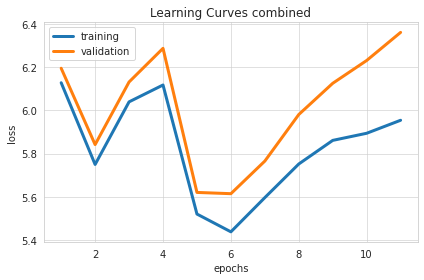

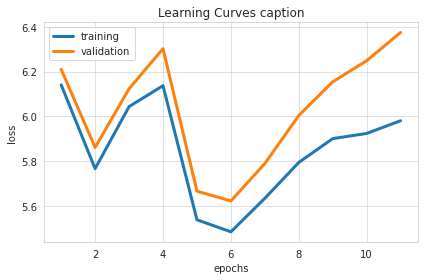

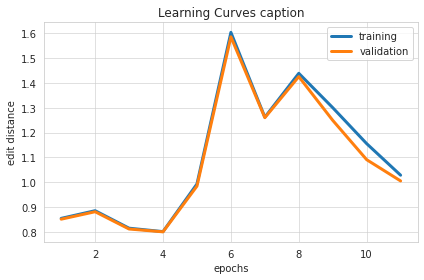

In [ ]:
from ludwig.visualize import learning_curves
learning_curves(
    train_stats_per_model = train_stats, 
    output_feature_name = None,
    output_directory='./visualizations',
    file_format='png'
)

Make predictions over the test set

In [ ]:
predictions, _ = model.predict(dataset=test_df)

Using in_memory = False is not supported with <class 'pandas.core.frame.DataFrame'> data format.
Prediction: 100%|██████████| 8/8 [00:01<00:00,  4.34it/s]


Concatenate the predictions to the test inputs

In [ ]:
predictions_df = test_df.assign(predictions = predictions["caption_predictions"])

In [ ]:
predictions_df.head()

,image_path,caption,predictions
0,/content/Flicker8k_Dataset/1056338697_4f7d7ce270.jpg,A blond woman in a blue shirt appears to wait for a ride,"[a, man, in, a, red, shirt, is, shirt, in, a, red, shirt, and, a, dog, in, a, red, shirt, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, ..."
1,/content/Flicker8k_Dataset/106490881_5a2dd9b7bd.jpg,A boy in his blue swim shorts at the beach,"[a, black, dog, is, running, in, a, field, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>..."
2,/content/Flicker8k_Dataset/1082379191_ec1e53f996.jpg,A lady and a man with no shirt sit on a dock,"[a, man, in, a, red, shirt, is, shirt, in, a, black, and, white, dog, in, a, black, and, white, dog, in, a, black, and, white, dog, <PAD>, <PAD>, ..."
3,/content/Flicker8k_Dataset/1084040636_97d9633581.jpg,A closeup of a white dog that is laying its head on its paws,"[a, man, in, a, black, and, white, dog, is, is, shirt, in, a, black, and, white, dog, in, a, black, and, white, dog, in, a, black, and, a, dog, <P..."
4,/content/Flicker8k_Dataset/1096395242_fc69f0ae5a.jpg,A boy with a toy gun,"[a, man, in, a, red, shirt, is, shirt, in, a, red, shirt, and, a, dog, in, a, black, and, a, dog, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>,..."


Print out some predictions and a test image

0      [a, man, in, a, red, shirt, is, shirt, in, a, red, shirt, and, a, dog, in, a, red, shirt, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, ...
1      [a, black, dog, is, running, in, a, field, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>...
2      [a, man, in, a, red, shirt, is, shirt, in, a, black, and, white, dog, in, a, black, and, white, dog, in, a, black, and, white, dog, <PAD>, <PAD>, ...
3      [a, man, in, a, black, and, white, dog, is, is, shirt, in, a, black, and, white, dog, in, a, black, and, white, dog, in, a, black, and, a, dog, <P...
4      [a, man, in, a, red, shirt, is, shirt, in, a, red, shirt, and, a, dog, in, a, black, and, a, dog, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>,...
                                                                               ...                                                                          
995    [a, black, dog, is, running, in, a, field, <PAD>, <

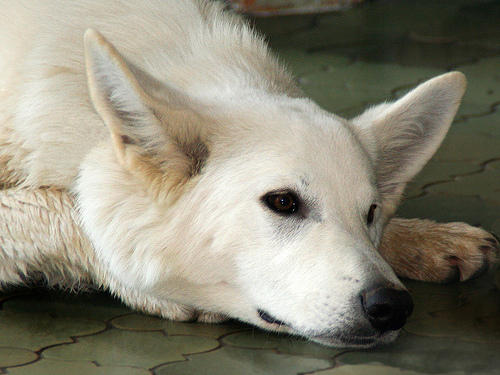

In [ ]:
from PIL import Image
pd.set_option('display.max_colwidth',150)

print(predictions_df.iloc[:]["predictions"])
Image.open(predictions_df.iloc[3]["image_path"])